In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from palmerpenguins import load_penguins
#import graphviz
#from sklearn.tree import convert_to_graphviz


%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')

## Cargando el conjunto de datos
Cargaremos el conjunto de datos para explorarlo. 

In [3]:
df_pinguinos = load_penguins()
df_pinguinos.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


El conjunto de datos está compuesto por 344 filas y 8 variables.

In [4]:
df_pinguinos.shape

(344, 8)

A continuación veremos como están distribuidas las variables del conjunto de datos.

In [5]:
df_pinguinos.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,342.000000,342.000000,342.000000,342.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386,2008.029070
std,5.459584,1.974793,14.061714,801.954536,0.818356
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.225000,15.600000,190.000000,3550.000000,2007.000000
50%,44.450000,17.300000,197.000000,4050.000000,2008.000000
75%,48.500000,18.700000,213.000000,4750.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


Las variables numéricas se encuentran en diferentes escalas, por lo que valdría la pena normalizarlas antes de usar un algoritmo.
Veamos ahora como están relacionadas algunas variables categóricas con las numéricas

Text(0, 0.5, 'Body Mass')

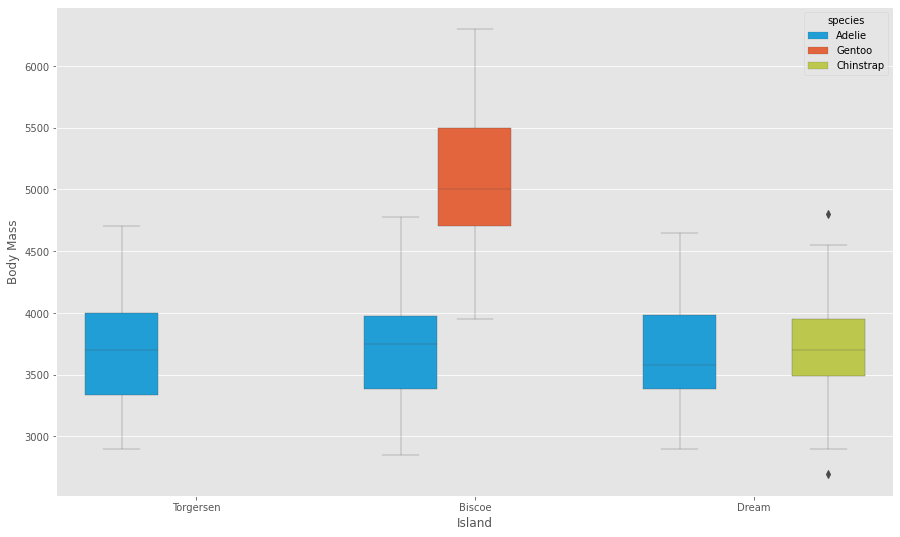

In [6]:
g = sb.boxplot(x = 'island',
            y ='body_mass_g',
            hue = 'species',
            data = df_pinguinos,
            palette=['#03A9F4','#FF5722','#CDDC39'],
            linewidth=0.3)
g.set_xlabel('Island')
g.set_ylabel('Body Mass')

Podemos observar que la especie Adelie está en las 3 islas mientras que las especies Gentoo y Ghinstrap están en las islas Biscoe y Dream respectivamente. La masa de los Gentoo es superior a todas las especies. Los Adelie son similares en la masa corporal no importa en la isla en la que habiten.

### Variable respuesta
La variable respuesta es la especie del pinguino, veamos que tan balanceado está nuesto conjunto de datos

In [7]:
df_pinguinos.groupby('species').size()

species
Adelie       152
Chinstrap     68
Gentoo       124
dtype: int64

<AxesSubplot:xlabel='Especie', ylabel='Cantidad'>

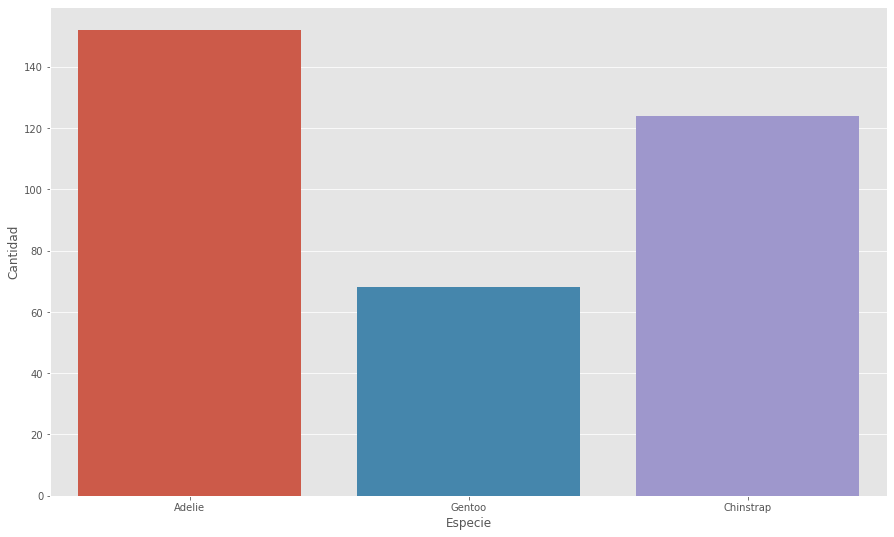

In [8]:
diccEspecie = {'Especie': df_pinguinos['species'].unique(), 'Cantidad': df_pinguinos.groupby('species').size()}
tbl_Specie = pd.DataFrame(diccEspecie)
sb.barplot(x="Especie",y="Cantidad", data=tbl_Specie)

Como se puede ver la variable respuesta no está del todo balanceada. Miremos las demas variables

## Algoritmo de Clasificación   
Se va a probar un algoritmo de máquinas vectoriales de soporte para clasificar un pinguino según la especie. 
Para esto vamos a dividir en conjuntos de entrenamiento (70%) y prueba (30%) los datos

In [9]:
target = df_pinguinos.pop('species')
data = df_pinguinos


In [10]:
random.seed(123)
data_train, data_test,target_train, target_test = train_test_split(data, target,test_size=0.3,train_size=0.7)
data_train.columns

Index(['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex', 'year'],
      dtype='object')

In [11]:
nombre_categoricas = ['island','sex']
nombre_numericas = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g','year']
categoricas = data[nombre_categoricas]
numericas = data[nombre_numericas]

from sklearn.impute import SimpleImputer


### Preprocesamiento
Vamos a preprocesar las variables numéricas de forma diferente a las variables categóricas, las numéricas las vamos a codificar y las numpericas a normalizar.

In [12]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_preprocessor = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Se preparan los preprocesadores
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")


#Se transforman las colunas usando los preprocesadores
from sklearn.compose import ColumnTransformer

preprocesador = ColumnTransformer([
    ('one_hot_encoder',categorical_preprocessor,nombre_categoricas),
    ('numerico', numeric_preprocessor,nombre_numericas)
],remainder="passthrough")

Vamos a hacer una tubería para que haga el preprocesamiento y el modelo en un solo paso. Vamos a usar una máquina vectorial de soporte con kernel lineal y con el valor de C por defecto.



In [13]:
from sklearn.pipeline import make_pipeline

modelo = make_pipeline(preprocesador, SVC(kernel="linear"))

# Esto nos permite ver dentro del modelo
from sklearn import set_config
set_config(display='diagram')
modelo

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['island', 'sex']),
                                                 ('numerico',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['bill_length_mm',
                                                   'bill_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g', 'year'])])),
                ('svc', SVC(kernel='linear'))])

En la figura anterior se puede ver lo que se le va a hacer al conjunto de datos para poder entrenar el modelo. A continuación entrenaremos el modelo.

In [22]:
_=modelo.fit(data_train,target_train)

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
274,Biscoe,45.2,14.8,212.0,5200.0,female,2009
339,Dream,55.8,19.8,207.0,4000.0,male,2009
149,Dream,37.8,18.1,193.0,3750.0,male,2009
7,Torgersen,39.2,19.6,195.0,4675.0,male,2007
52,Biscoe,35.0,17.9,190.0,3450.0,female,2008
...,...,...,...,...,...,...,...
279,Dream,45.4,18.7,188.0,3525.0,female,2007
42,Dream,36.0,18.5,186.0,3100.0,female,2007
197,Biscoe,43.6,13.9,217.0,4900.0,female,2008
185,Biscoe,59.6,17.0,230.0,6050.0,male,2007


Podemos ver ahora el accuracy del modelo

In [15]:

modelo.score(data_test,target_test)

1.0

In [16]:
target_pred = modelo.predict(data_test)
print(target_pred)
print ("Accuracy:",metrics.accuracy_score(target_test, target_pred))
print ("Precision:", metrics.precision_score(target_test,target_pred,average='weighted') )
print ("Recall: ", metrics.recall_score(target_test,target_pred,average='weighted'))


['Gentoo' 'Gentoo' 'Gentoo' 'Gentoo' 'Gentoo' 'Chinstrap' 'Adelie'
 'Adelie' 'Gentoo' 'Gentoo' 'Gentoo' 'Gentoo' 'Adelie' 'Gentoo'
 'Chinstrap' 'Chinstrap' 'Gentoo' 'Gentoo' 'Adelie' 'Chinstrap' 'Gentoo'
 'Gentoo' 'Adelie' 'Gentoo' 'Adelie' 'Adelie' 'Adelie' 'Gentoo' 'Gentoo'
 'Gentoo' 'Gentoo' 'Gentoo' 'Gentoo' 'Adelie' 'Gentoo' 'Gentoo'
 'Chinstrap' 'Gentoo' 'Adelie' 'Adelie' 'Gentoo' 'Adelie' 'Adelie'
 'Adelie' 'Gentoo' 'Adelie' 'Chinstrap' 'Adelie' 'Chinstrap' 'Gentoo'
 'Adelie' 'Chinstrap' 'Gentoo' 'Gentoo' 'Adelie' 'Chinstrap' 'Chinstrap'
 'Gentoo' 'Adelie' 'Gentoo' 'Gentoo' 'Gentoo' 'Gentoo' 'Adelie' 'Adelie'
 'Adelie' 'Gentoo' 'Gentoo' 'Adelie' 'Gentoo' 'Chinstrap' 'Gentoo'
 'Adelie' 'Gentoo' 'Gentoo' 'Gentoo' 'Chinstrap' 'Gentoo' 'Adelie'
 'Adelie' 'Adelie' 'Chinstrap' 'Gentoo' 'Gentoo' 'Chinstrap' 'Gentoo'
 'Adelie' 'Adelie' 'Adelie' 'Adelie' 'Gentoo' 'Adelie' 'Gentoo' 'Gentoo'
 'Adelie' 'Chinstrap' 'Adelie' 'Adelie' 'Chinstrap' 'Gentoo' 'Chinstrap'
 'Adelie' 'Adelie' 'Gentoo

Vemos que el modelo tiene un accuracy de casi el 100% lo que puede resultar sospechoso, si analizamos la matriz de confusión abajo vemos que solo se equivocó una vez el algoritmo. Vamos a usar validación cruzada para ver si eso cambia.

In [17]:
from sklearn.metrics import  confusion_matrix
confusion_matrix(target_pred, target_test)

array([[37,  0,  0],
       [ 0, 17,  0],
       [ 0,  0, 50]], dtype=int64)

## Validación Cruzada

Usaremos kfolds, vamos a usar 10.

In [18]:
from sklearn.model_selection import cross_validate, cross_val_predict
cv = 10
cv_results = cross_validate(modelo,data, target, cv=cv)
cv_results = pd.DataFrame(cv_results)
print("accuracy: "+cv_results['test_score'].mean())

TypeError: can only concatenate str (not "numpy.float64") to str

Usando validación cruzada el modelo mejoró un poco. Veamos la matriz de confusión

In [ ]:
target_pred = cross_val_predict(modelo, data, target, cv = cv)
confusion_matrix(target, target_pred)

array([[150,   1,   1],
       [  1,  67,   0],
       [  1,   0, 123]], dtype=int64)

Se equivoca más veces el modelo, la validación cruzada ayuda que a que mejorar el sobreajuste
### Tuneando los parámetros

Hagamos varios modelos con varios valores del margen a ver cual es el mejor modelo

In [ ]:
modelo.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'svc', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__one_hot_encoder', 'columntransformer__numerico', 'columntransformer__one_hot_encoder__categories', 'columntransformer__one_hot_encoder__drop', 'columntransformer__one_hot_encoder__dtype', 'columntransformer__one_hot_encoder__handle_unknown', 'columntransformer__one_hot_encoder__sparse', 'columntransformer__numerico__memory', 'columntransformer__numerico__steps', 'columntransformer__numerico__verbose', 'columntransformer__numerico__imputer', 'columntransformer__numerico__scaler', 'columntransformer__numerico__imputer__add_indicator', 'columntransformer__numerico__imputer__copy', 'columntransformer__numerico__imputer__fill_value', 'columntransformer_

In [ ]:
modelo = make_pipeline(preprocesador, SVC(kernel="poly"))
_=modelo.fit(data_train,target_train)
param_grid = {
    'svc__C': (0.01, 0.1, 1, 5,16,32),
    'svc__degree':(2,3,5,7)
    }
model_grid_search = GridSearchCV(modelo, param_grid=param_grid,
                                 n_jobs=2, cv=10)
model_grid_search.fit(data_train, target_train)
accuracy = model_grid_search.score(data_test, target_test)
print("Accuracy: ",accuracy)
model_grid_search.best_params_

Accuracy:  0.9903846153846154


{'svc__C': 1, 'svc__degree': 2}

In [ ]:
modelo = make_pipeline(preprocesador, SVC(kernel="rbf"))
_=modelo.fit(data_train,target_train)
param_grid = {
    'svc__C': (0.01, 0.1, 1, 5,16,32),
    'svc__gamma':(0.0000000002,0.00002,0.01,0.1,20,200)
    }
model_grid_search = GridSearchCV(modelo, param_grid=param_grid,
                                 n_jobs=2, cv=10)
model_grid_search.fit(data_train, target_train)
accuracy = model_grid_search.score(data_test, target_test)
print("Accuracy: ",accuracy)
model_grid_search.best_params_

Accuracy:  1.0


{'svc__C': 5, 'svc__gamma': 0.1}

In [ ]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
26,0.007382,0.001014,0.003893,0.000531,16,0.01,"{'svc__C': 16, 'svc__gamma': 0.01}",1.000000,0.958333,1.000000,1.000000,0.958333,1.000000,1.000000,1.000000,1.000000,1.000000,0.991667,0.016667,1
21,0.007473,0.000499,0.003594,0.000493,5,0.1,"{'svc__C': 5, 'svc__gamma': 0.1}",1.000000,0.958333,1.000000,1.000000,0.958333,1.000000,1.000000,1.000000,1.000000,1.000000,0.991667,0.016667,1
20,0.007179,0.000738,0.003497,0.000493,5,0.01,"{'svc__C': 5, 'svc__gamma': 0.01}",1.000000,0.958333,1.000000,1.000000,0.958333,1.000000,1.000000,1.000000,0.958333,1.000000,0.987500,0.019094,3
32,0.007182,0.000399,0.003490,0.000498,32,0.01,"{'svc__C': 32, 'svc__gamma': 0.01}",1.000000,0.958333,0.958333,1.000000,0.958333,1.000000,1.000000,1.000000,1.000000,1.000000,0.987500,0.019094,3
15,0.008127,0.001464,0.003490,0.001351,1,0.1,"{'svc__C': 1, 'svc__gamma': 0.1}",1.000000,0.958333,1.000000,1.000000,0.958333,1.000000,1.000000,1.000000,0.958333,1.000000,0.987500,0.019094,3
14,0.007684,0.000634,0.003988,0.000626,1,0.01,"{'svc__C': 1, 'svc__gamma': 0.01}",1.000000,1.000000,1.000000,1.000000,0.958333,1.000000,0.958333,1.000000,0.958333,1.000000,0.987500,0.019094,3
33,0.006982,0.000446,0.003490,0.000669,32,0.1,"{'svc__C': 32, 'svc__gamma': 0.1}",1.000000,0.958333,0.958333,1.000000,0.958333,1.000000,0.958333,1.000000,1.000000,1.000000,0.983333,0.020412,7
27,0.007181,0.000399,0.003583,0.000490,16,0.1,"{'svc__C': 16, 'svc__gamma': 0.1}",1.000000,0.958333,0.958333,1.000000,0.958333,1.000000,0.958333,1.000000,1.000000,1.000000,0.983333,0.020412,7
9,0.008186,0.000409,0.003788,0.000584,0.1,0.1,"{'svc__C': 0.1, 'svc__gamma': 0.1}",1.000000,0.958333,1.000000,1.000000,0.958333,1.000000,0.916667,0.958333,0.958333,1.000000,0.975000,0.027639,9
8,0.008668,0.000902,0.004292,0.000774,0.1,0.01,"{'svc__C': 0.1, 'svc__gamma': 0.01}",0.791667,0.791667,0.791667,0.791667,0.750000,0.791667,0.750000,0.750000,0.750000,0.750000,0.770833,0.020833,10


Como se ve en los modelos anteriores no se logra mejorar el sobreajuste.

### Conclusión

En este notebook se mostró un ejemplo de como trabajar con un clasificador usando una máquina vectorial de soporte. Se preprocesaron las variables numéricas y categóricas por separado. Se hizo un modelo con validación cruzada, y se modificaron los parámetros del clasificador.